In this part of the series, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

# Setup

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [13]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [14]:
df = pd.read_csv("data/creditcard.csv")

# Exploration

In [15]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [16]:
df.isnull().values.any()

False

C:\Users\OGYAM\AppData\Local\Temp\ipykernel_37772\2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


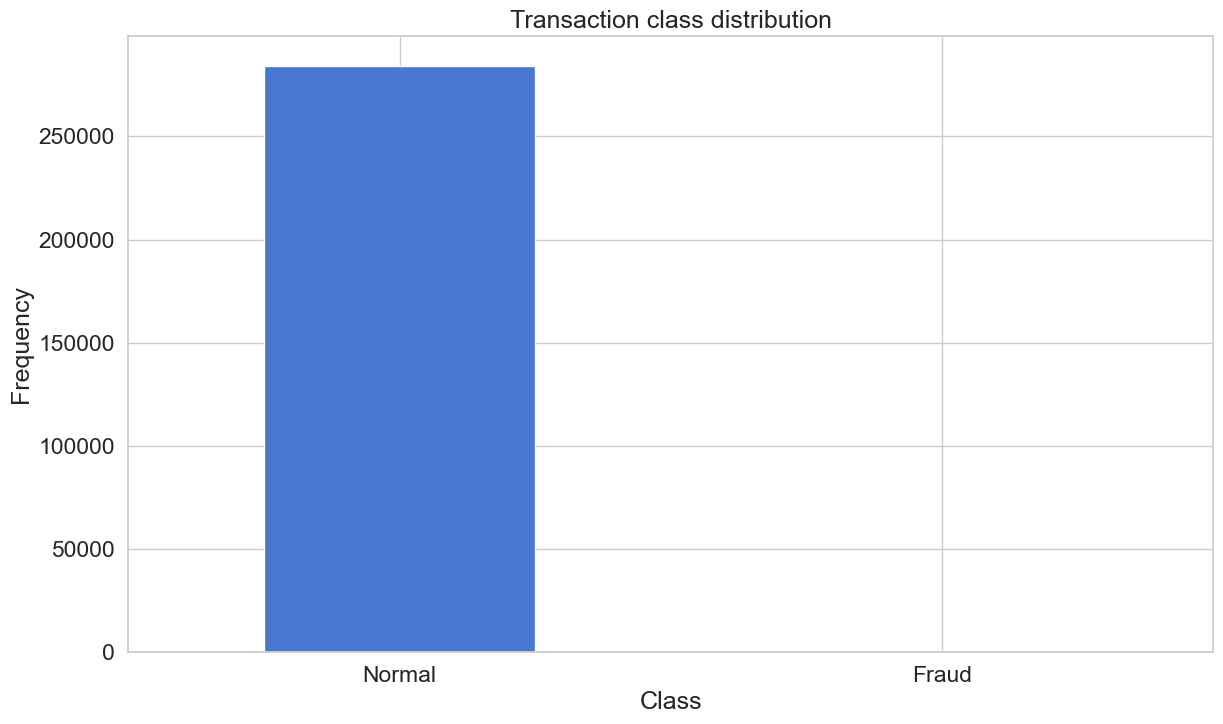

In [17]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [18]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [19]:
fraud_size = frauds.shape

fraud_size

(492, 31)

In [20]:
normal_size = normal.shape

normal_size

(284315, 31)

In [21]:
100*fraud_size[0]/normal_size[0]

0.17304750013189596

How different are the amount of money used in different transaction classes?

In [22]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [23]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

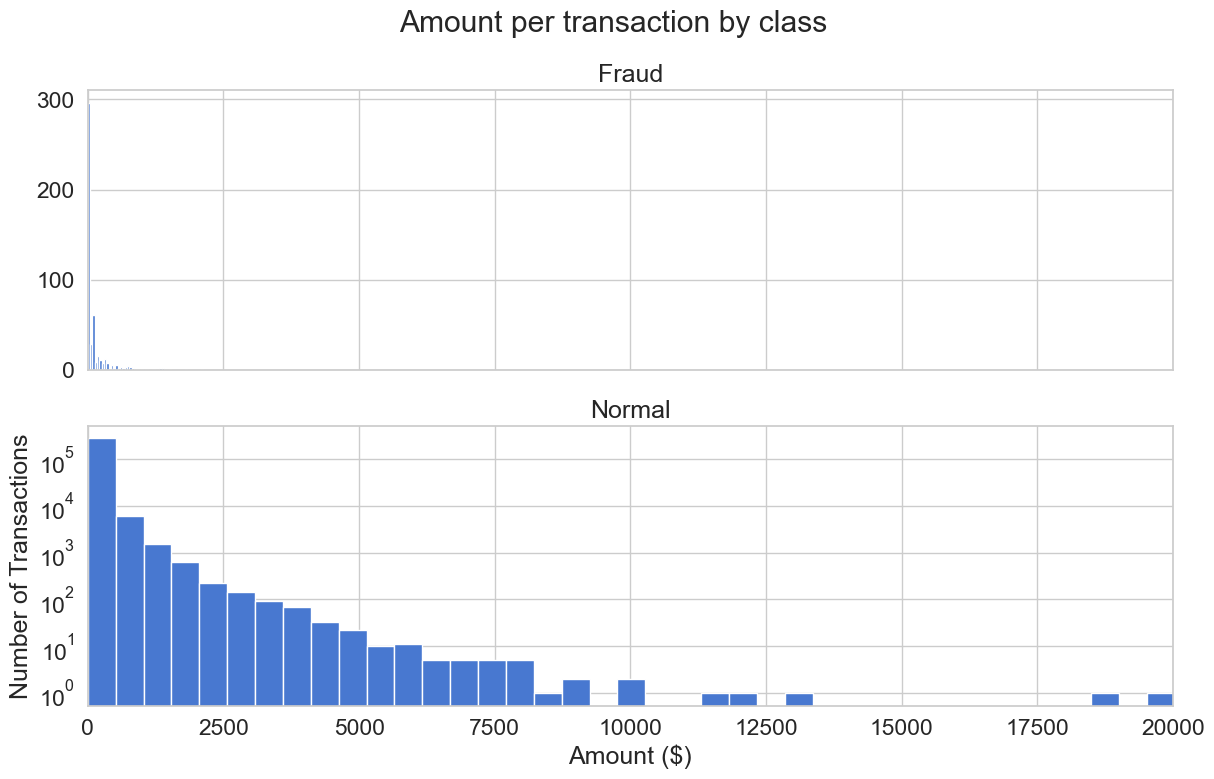

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

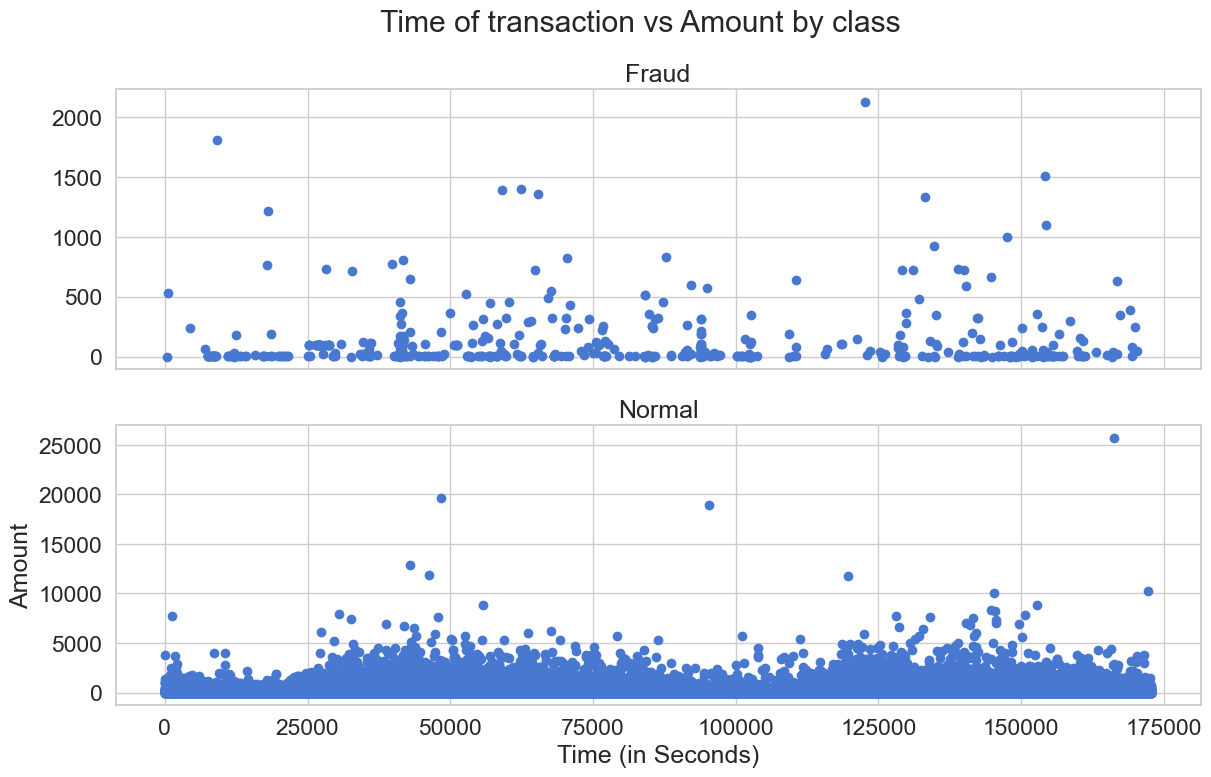

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

<iframe width="100%" height="480" src="https://www.youtube.com/embed/FzS3tMl4Nsc" frameborder="0" allowfullscreen></iframe>

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [26]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [27]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [28]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [29]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [30]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [31]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5092 - loss: 0.8815

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.5872 - loss: 0.8131 - val_accuracy: 0.6376 - val_loss: 0.7929
Epoch 2/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6392 - loss: 0.7540

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6444 - loss: 0.7546 - val_accuracy: 0.6551 - val_loss: 0.7804
Epoch 3/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6582 - loss: 0.7416

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6622 - loss: 0.7465 - val_accuracy: 0.6672 - val_loss: 0.7754
Epoch 4/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6700 - loss: 0.7446

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6706 - loss: 0.7433 - val_accuracy: 0.6759 - val_loss: 0.7735
Epoch 5/100
7102/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6731 - loss: 0.7461

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6729 - loss: 0.7402 - val_accuracy: 0.6751 - val_loss: 0.7720
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6747 - loss: 0.7385 - val_accuracy: 0.6745 - val_loss: 0.7725
Epoch 7/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6772 - loss: 0.7259

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6767 - loss: 0.7374 - val_accuracy: 0.6714 - val_loss: 0.7712
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6780 - loss: 0.7459

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.6779 - loss: 0.7357 - val_accuracy: 0.6838 - val_loss: 0.7681
Epoch 9/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6778 - loss: 0.7455

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.6786 - loss: 0.7346 - val_accuracy: 0.6824 - val_loss: 0.7676
Epoch 10/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6794 - loss: 0.7583

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.6787 - loss: 0.7340 - val_accuracy: 0.6781 - val_loss: 0.7673
Epoch 11/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.6789 - loss: 0.7332 - val_accuracy: 0.6838 - val_loss: 0.7675
Epoch 12/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.6806 - loss: 0.7326 - val_accuracy: 0.6788 - val_loss: 0.7693
Epoch 13/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6810 - loss: 0.7391

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6807 - loss: 0.7319 - val_accuracy: 0.6837 - val_loss: 0.7664
Epoch 14/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.6812 - loss: 0.7318 - val_accuracy: 0.6803 - val_loss: 0.7812
Epoch 15/100
7097/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6801 - loss: 0.7174

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6818 - loss: 0.7313 - val_accuracy: 0.6820 - val_loss: 0.7652
Epoch 16/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6820 - loss: 0.7301

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6813 - loss: 0.7313 - val_accuracy: 0.6856 - val_loss: 0.7640
Epoch 17/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6820 - loss: 0.7306 - val_accuracy: 0.6862 - val_loss: 0.7643
Epoch 18/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6825 - loss: 0.7308 - val_accuracy: 0.6843 - val_loss: 0.7650
Epoch 19/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6807 - loss: 0.7258

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6818 - loss: 0.7305 - val_accuracy: 0.6829 - val_loss: 0.7633
Epoch 20/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6828 - loss: 0.7302 - val_accuracy: 0.6880 - val_loss: 0.7649
Epoch 21/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6827 - loss: 0.7302 - val_accuracy: 0.6773 - val_loss: 0.7645
Epoch 22/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6827 - loss: 0.7304 - val_accuracy: 0.6843 - val_loss: 0.7635
Epoch 23/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6818 - loss: 0.7299 - val_accuracy: 0.6806 - val_loss: 0.7635
Epoch 24/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6829 - loss: 0.7298 - val_accuracy: 0.6892 - val_loss: 0.7639
Epoch 25/100
7102/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6835 - loss: 0.7206

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.6832 - loss: 0.7301 - val_accuracy: 0.6859 - val_loss: 0.7632
Epoch 26/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6830 - loss: 0.7294 - val_accuracy: 0.6767 - val_loss: 0.7652
Epoch 27/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6833 - loss: 0.7293 - val_accuracy: 0.6793 - val_loss: 0.7672
Epoch 28/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6826 - loss: 0.7290 - val_accuracy: 0.6827 - val_loss: 0.7670
Epoch 29/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6824 - loss: 0.7304

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6819 - loss: 0.7296 - val_accuracy: 0.6846 - val_loss: 0.7627
Epoch 30/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6833 - loss: 0.7290 - val_accuracy: 0.6812 - val_loss: 0.7637
Epoch 31/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6827 - loss: 0.7291 - val_accuracy: 0.6843 - val_loss: 0.7633
Epoch 32/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6822 - loss: 0.7290 - val_accuracy: 0.6842 - val_loss: 0.7635
Epoch 33/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6833 - loss: 0.7289 - val_accuracy: 0.6767 - val_loss: 0.7715
Epoch 34/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6834 - loss: 0.7291 - val_accuracy: 0.6814 - val_loss: 0.7638
Epoch 35/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6831 - loss: 0.7289 - val_accuracy: 0.6782 - val_loss: 0.7660
Epoch 36/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6831 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6835 - loss: 0.7288 - val_accuracy: 0.6828 - val_loss: 0.7620
Epoch 40/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6827 - loss: 0.7287 - val_accuracy: 0.6837 - val_loss: 0.7634
Epoch 41/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6846 - loss: 0.7284 - val_accuracy: 0.6904 - val_loss: 0.7624
Epoch 42/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6835 - loss: 0.7291 - val_accuracy: 0.6845 - val_loss: 0.7634
Epoch 43/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6838 - loss: 0.7282 - val_accuracy: 0.6833 - val_loss: 0.7656
Epoch 44/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6830 - loss: 0.7286 - val_accuracy: 0.6829 - val_loss: 0.7644
Epoch 45/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6841 - loss: 0.7281 - val_accuracy: 0.6809 - val_loss: 0.7653
Epoch 46/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6835 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6844 - loss: 0.7283 - val_accuracy: 0.6919 - val_loss: 0.7615
Epoch 52/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6845 - loss: 0.7282 - val_accuracy: 0.6835 - val_loss: 0.7627
Epoch 53/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6839 - loss: 0.7281 - val_accuracy: 0.6854 - val_loss: 0.7615
Epoch 54/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.6844 - loss: 0.7287 - val_accuracy: 0.6799 - val_loss: 0.7628
Epoch 55/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6839 - loss: 0.7281 - val_accuracy: 0.6863 - val_loss: 0.7635
Epoch 56/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6849 - loss: 0.7283 - val_accuracy: 0.6803 - val_loss: 0.7661
Epoch 57/100
7098/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6837 - loss: 0.7364

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6843 - loss: 0.7281 - val_accuracy: 0.6886 - val_loss: 0.7614
Epoch 58/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.6846 - loss: 0.7282 - val_accuracy: 0.6825 - val_loss: 0.7627
Epoch 59/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6846 - loss: 0.7283 - val_accuracy: 0.6833 - val_loss: 0.7626
Epoch 60/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6841 - loss: 0.7278 - val_accuracy: 0.6897 - val_loss: 0.7657
Epoch 61/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6841 - loss: 0.7284 - val_accuracy: 0.6825 - val_loss: 0.7626
Epoch 62/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6837 - loss: 0.7282 - val_accuracy: 0.6891 - val_loss: 0.7624
Epoch 63/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6842 - loss: 0.7276 - val_accuracy: 0.6842 - val_loss: 0.7631
Epoch 64/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6844 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6847 - loss: 0.7277 - val_accuracy: 0.6895 - val_loss: 0.7605
Epoch 68/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6843 - loss: 0.7277 - val_accuracy: 0.6822 - val_loss: 0.7617
Epoch 69/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6838 - loss: 0.7279 - val_accuracy: 0.6821 - val_loss: 0.7621
Epoch 70/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6841 - loss: 0.7282 - val_accuracy: 0.6884 - val_loss: 0.7652
Epoch 71/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6845 - loss: 0.7277 - val_accuracy: 0.6826 - val_loss: 0.7621
Epoch 72/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6841 - loss: 0.7277 - val_accuracy: 0.6858 - val_loss: 0.7615
Epoch 73/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6849 - loss: 0.7277 - val_accuracy: 0.6794 - val_loss: 0.7624
Epoch 74/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6839 - loss

In [32]:
autoencoder = load_model('model.h5')

# Evaluation

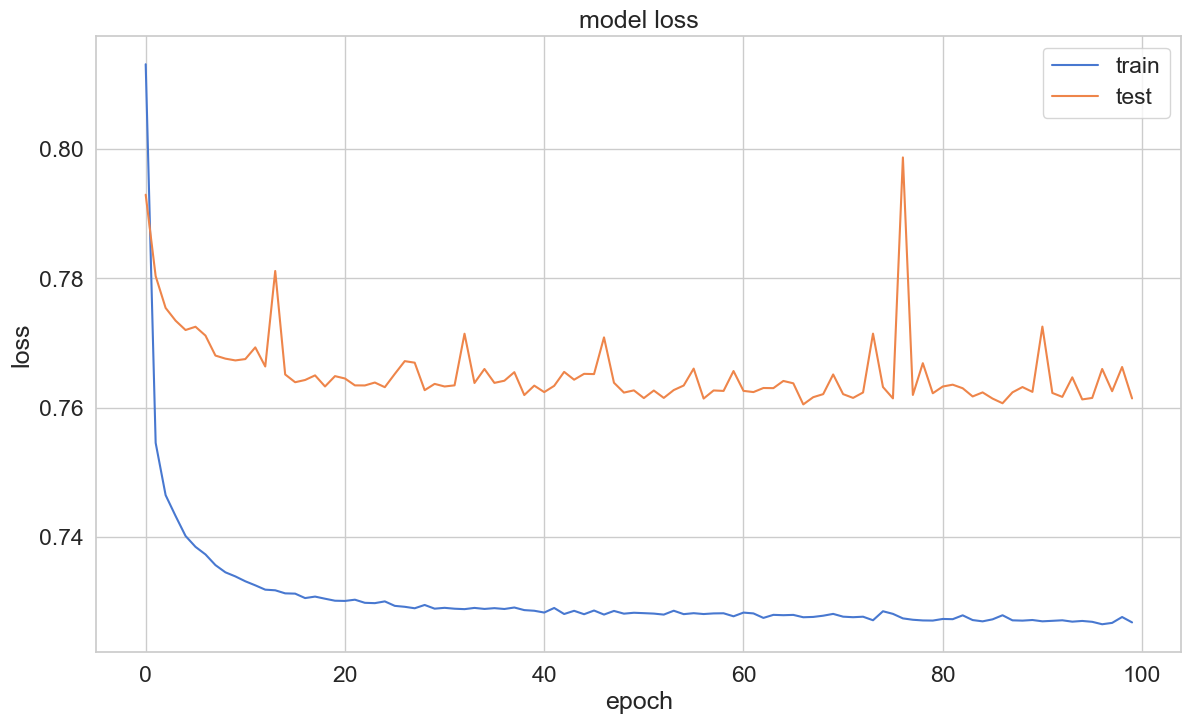

In [33]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [34]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [ ]:
# Calculate fraud score
fraud_scores = np.mean(np.power(X_test - predictions, 2), axis=1)

for i, score in enumerate(fraud_scores):
    print(f"Transaction {i}: Fraud score = {score}")

In [35]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [36]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.752560,0.001720
std,3.461670,0.041443
min,0.058682,0.000000
25%,0.241783,0.000000
50%,0.390929,0.000000
75%,0.621733,0.000000
max,261.148846,1.000000


## Reconstruction error without fraud

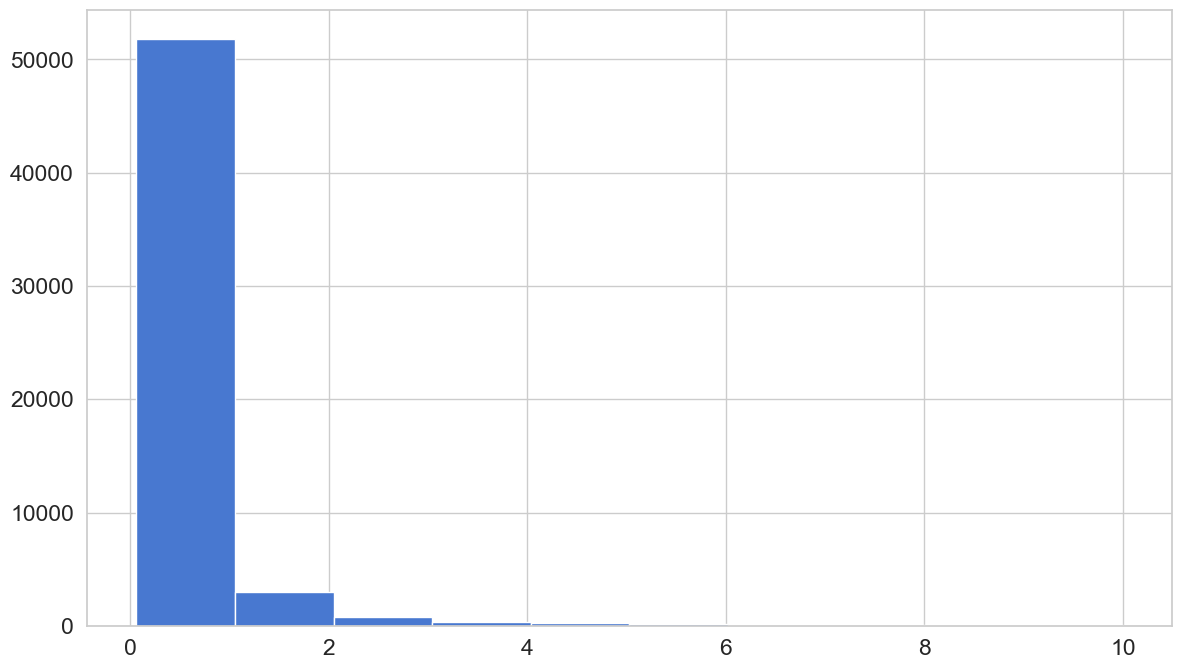

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

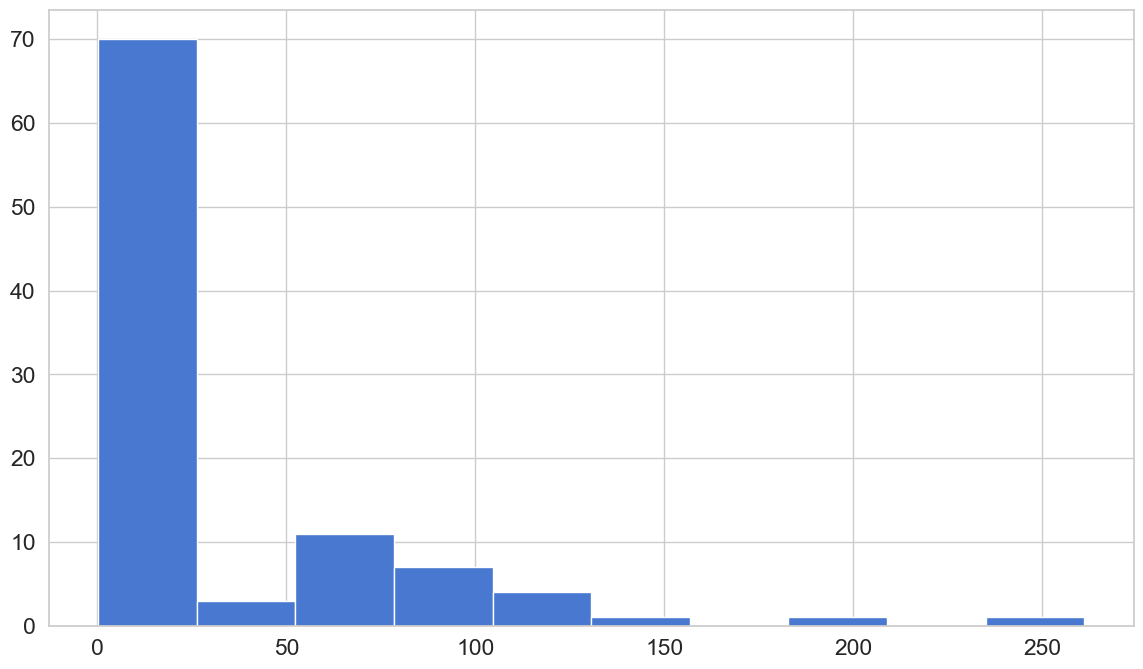

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [39]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

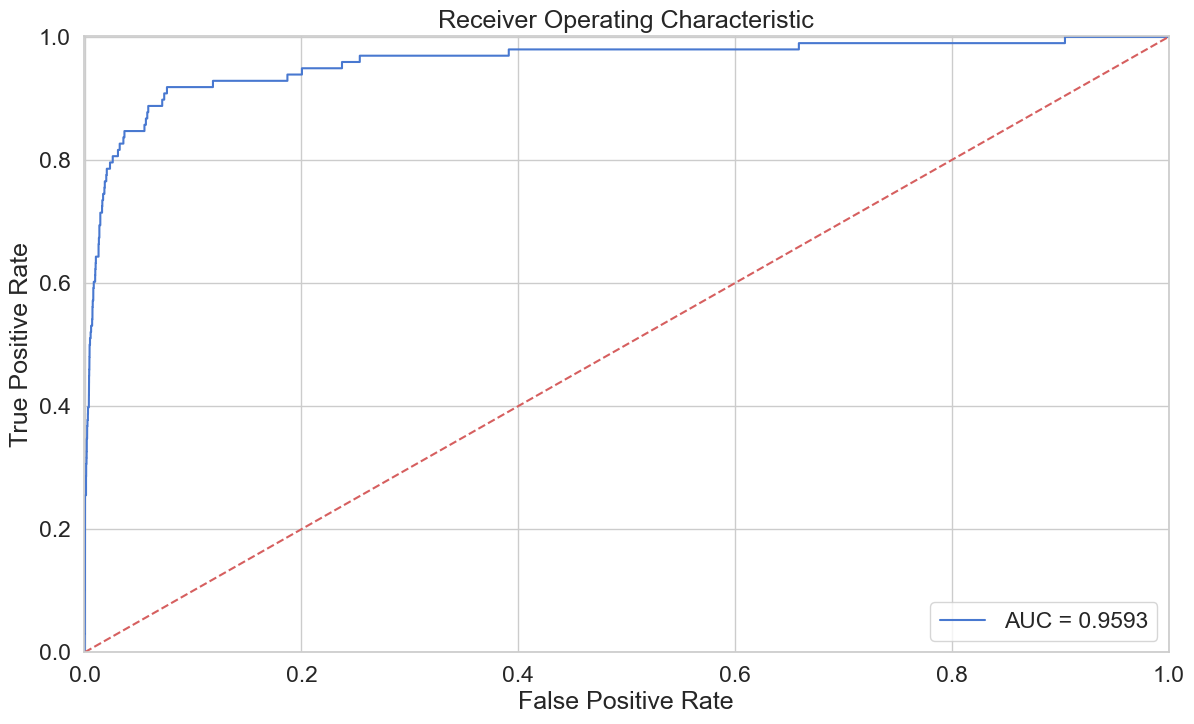

In [40]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

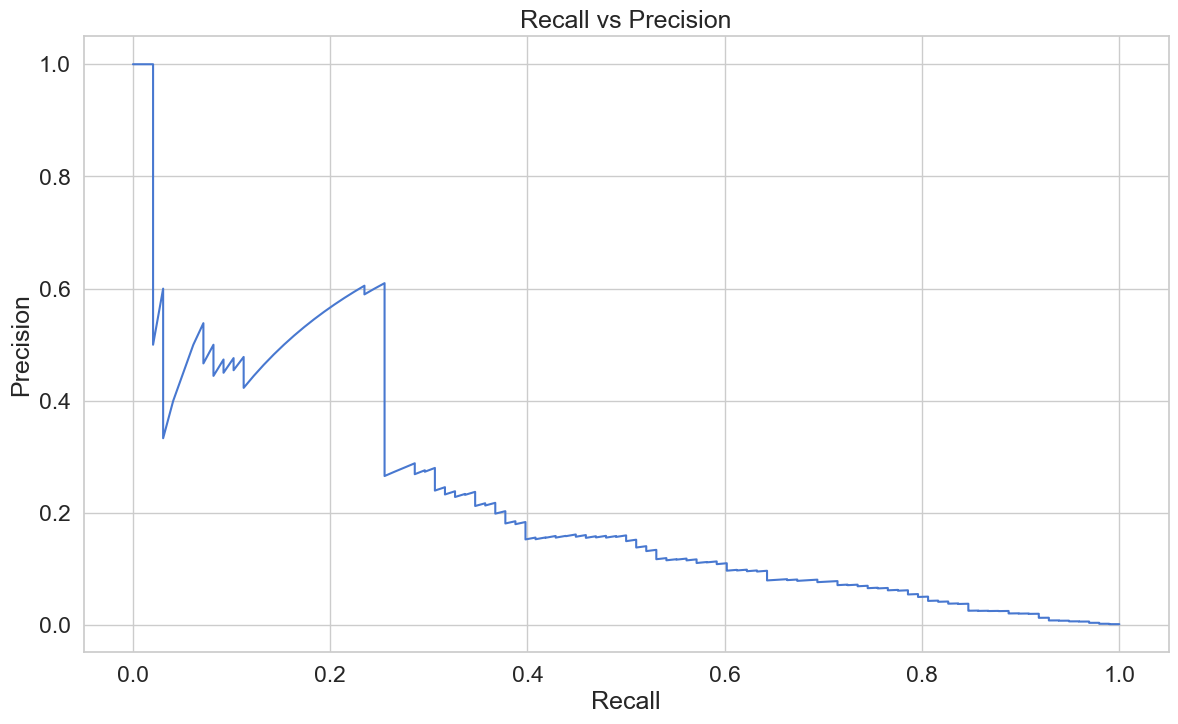

In [41]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

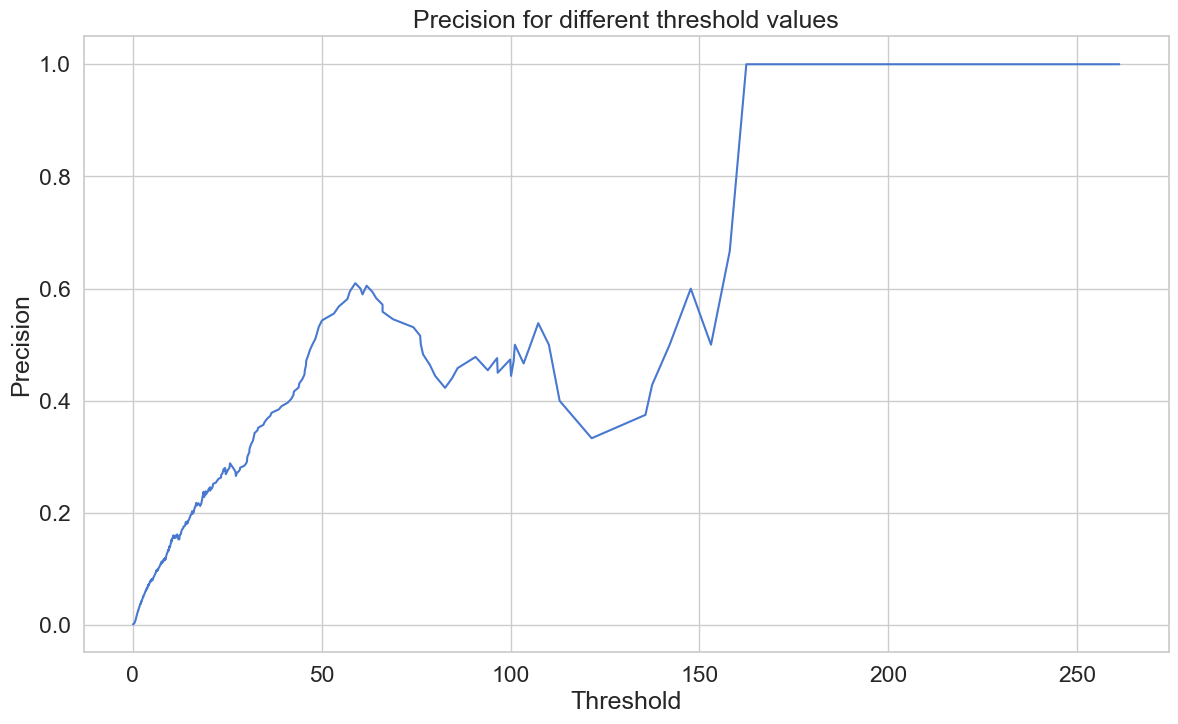

In [42]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

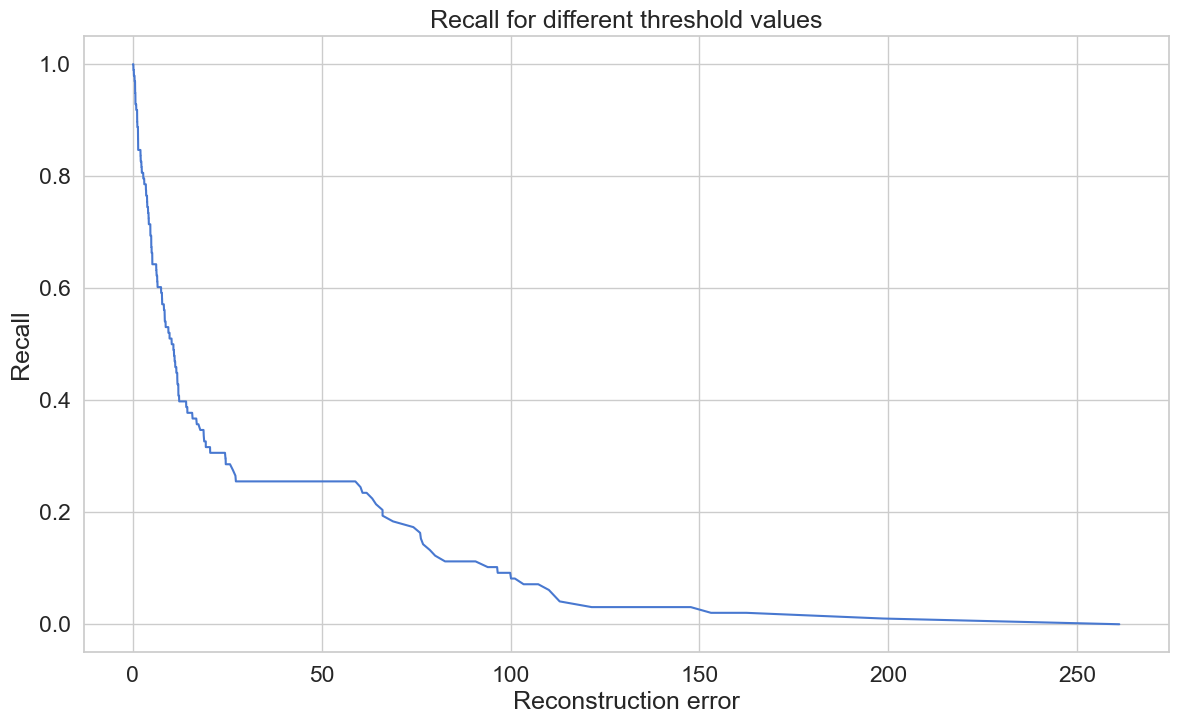

In [43]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [44]:
threshold = 2.9

And see how well we're dividing the two types of transactions:

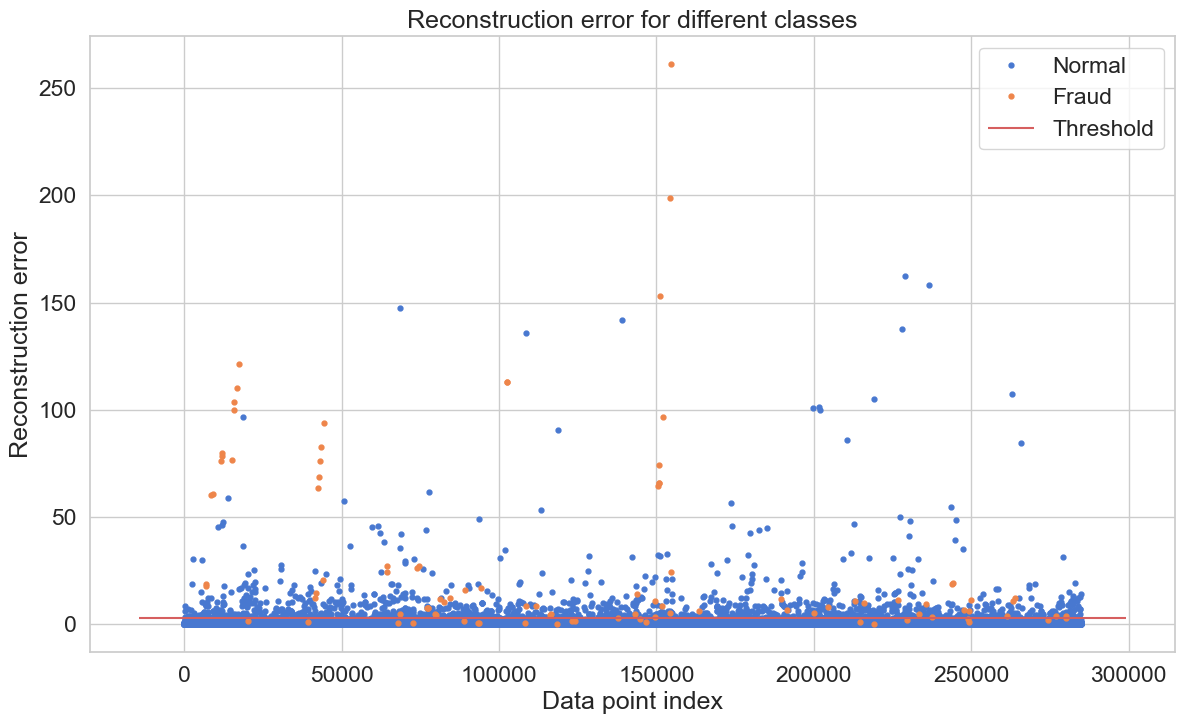

In [45]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

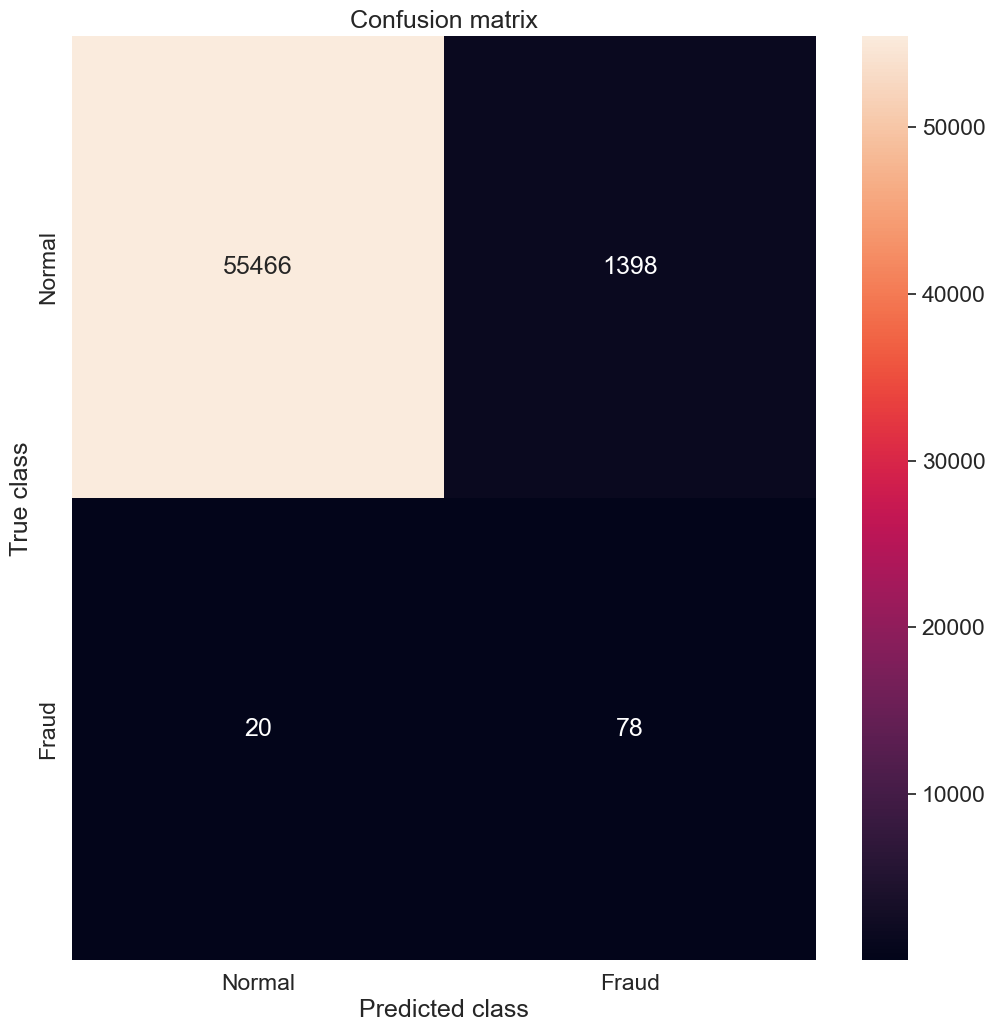

In [46]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)